# Trabalho No. 4

- Aluno: Guilherme Lisboa de Oliveira (GRR20170414)

```{admonition} Questão

Utilize os dados no arquivo **danishlc**, os dados fornecem o número de casos de câncer de pulmão em quatro cidades dinamarquesas entre 1968 e 1971 inclusive. O arquivo de dados contêm 24 observações nas 4 variáveis a seguir:

**Cases** o número de casos de câncer de pulmão; um vetor numérico (resposta)

**Popa** população de cada faixa etária em cada cidade; um vetor numérico

**Age** a faixa etária; um fator com níveis 40-54, 55-59, 60-64, 65-69, 70-74 e >74

**City** a cidade; um fator com os níveis Fredericia, Horsens, Kolding e Vejle

```

## Importando os dados

In [224]:
import pandas as pd

dataset = pd.read_table("./danish.txt", sep=",")
dataset.City = dataset.City.astype(pd.CategoricalDtype())

faixas_etarias = pd.CategoricalDtype(
    ["40-54", "55-59", "60-64", "65-69", "70-74", ">74"], ordered=True
)
dataset.Age = dataset.Age.astype(faixas_etarias)

dataset


,Cases,Pop,Age,City
0,11,3059,40-54,Fredericia
1,11,800,55-59,Fredericia
2,11,710,60-64,Fredericia
3,10,581,65-69,Fredericia
4,11,509,70-74,Fredericia
5,10,605,>74,Fredericia
6,13,2879,40-54,Horsens
7,6,1083,55-59,Horsens
8,15,923,60-64,Horsens
9,10,834,65-69,Horsens


## Análise exploratória

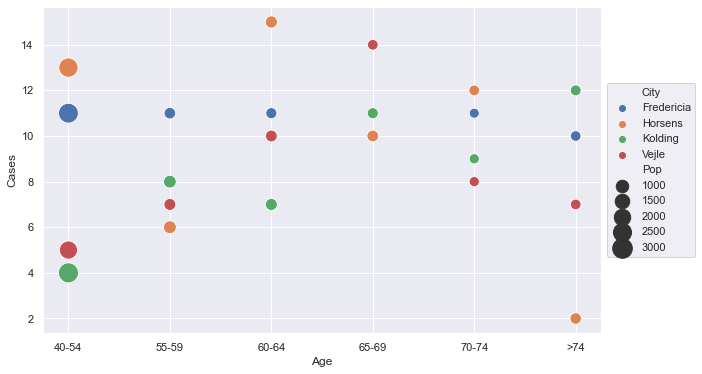

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_theme("notebook")
sns.set(rc={"figure.figsize": [10, 6]})

g = sns.scatterplot(
    data=dataset,
    x="Age",
    y="Cases",
    hue="City",
    size="Pop",
    sizes=(100, 400),
)
g.legend(loc="center left", bbox_to_anchor=(1, 0.5))

g;


Nota-se que a população descresce com o avanço da idade, assim, uma medida mais interessante é a taxa casos a cada 100 habitantes.

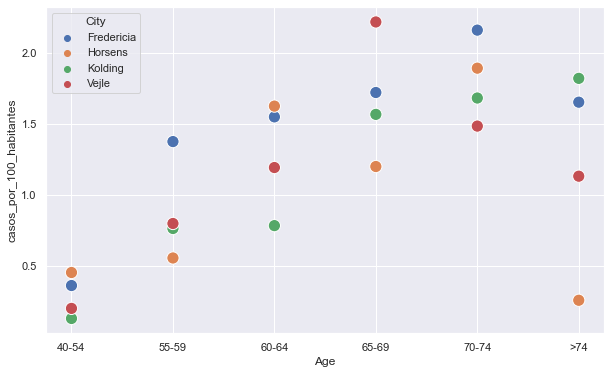

In [226]:
dataset["casos_por_100_habitantes"] = dataset.Cases / (dataset.Pop / 100)

g = sns.scatterplot(
    data=dataset, x="Age", y="casos_por_100_habitantes", hue="City", s=150
)

g;


Também pode ser interessante conectar os pontos de cada cidade e buscar vizualizar se alguma cidade está com taxas mais altas ou mais baixas conforme o avanço das faixas etárias. No gráfico abaixo, nota-se que Fredericia geralmente é a primeira ou a segunda cidade com as taxas mais altas. As demais, inicialmente, não apresentam um padrão claro em relação as demais.

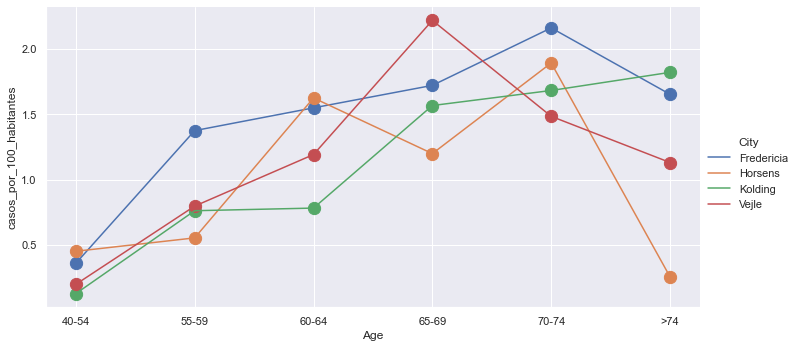

In [227]:
g = sns.FacetGrid(data=dataset, hue="City", height=5, aspect=2)
g.map(plt.scatter, "Age", "casos_por_100_habitantes", s=150)
g.map(plt.plot, "Age", "casos_por_100_habitantes")
g.add_legend()

g;


## Modelo

O modelo escolhido é o linear generalizado da familia Poisson. Utilizando a População como offset, Idade e Cidade como variáveis explicativas.

In [228]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

offset = np.log(dataset.Pop)

modelo = smf.glm(
    "Cases ~ Age + City",
    data=dataset,
    family=sm.families.Poisson(),
    offset=offset,
)

ajuste = modelo.fit()

ajuste.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Cases   No. Observations:                   24
Model:                            GLM   Df Residuals:                       15
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.918
Date:                Wed, 04 May 2022   Deviance:                       23.447
Time:                        16:09:55   Pearson chi2:                     22.6
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9882
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.6321      0.200    -28.125      0.000      -6.025      -5.240
Age[T.55-59]        1.1010      0.248      4.434      0.000       0.614       1.588
Age[T.60-64]        1.5186      0.232      6.556      0.000       1.065       1.973
Age[T.65-69]        1.7677      0.229      7.704      0.000       1.318       2.217
Age[T.70-74]        1.8569      0.235      7.891      0.000       1.396       2.318
Age[T.>74]          1.4197      0.250      5.672      0.000       0.929       1.910
City[T.Horsens]    -0.3301      0.182     -1.818      0.069      -0.686       0.026
City[T.Kolding]    -0.3715      0.188     -1.978      0.048      -0.740      -0.003
City[T.Vejle]      -0.2723      0.188     -1.450      0.147      -0.641       0.096
===================================================================================
"""

Nota-se que os coeficientes das Idades são determinates na predição do número casos. Já as cidades apresentaram p-valores mais altos, entretanto todas indicam que há uma redução no número de casos em relação a cidade de referência (intercept): Fredericia, conforme suspeita mencionada na análise exploratória.

Abaixo temos os valores preditos pelo modelo para cada combinação de Idade e Cidade:

In [229]:
predicoes = ajuste.get_prediction(offset=offset)

dataset.join(predicoes.summary_frame()).iloc[:, np.r_[0:4,5]]

,Cases,Pop,Age,City,mean
0,11,3059,40-54,Fredericia,10.954812
1,11,800,55-59,Fredericia,8.615485
2,11,710,60-64,Fredericia,11.609373
3,10,581,65-69,Fredericia,12.187276
4,11,509,70-74,Fredericia,11.672630
5,10,605,>74,Fredericia,8.960422
6,13,2879,40-54,Horsens,7.411803
7,6,1083,55-59,Horsens,8.384458
8,15,923,60-64,Horsens,10.849479
9,10,834,65-69,Horsens,12.576313
